In [1]:
import mlflow
import mlflow
import pickle

logged_model = 'runs:/0bca94481fa84654ae96435f3adc5f6c/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [24]:

# Ouvrir le fichier binaire en mode lecture (rb pour read binary)
with open("models/preprocessor.b", "rb") as f_in:
    dv = pickle.load(f_in)

# Vous pouvez maintenant utiliser l'objet chargé comme bon vous semble
print(dv)


DictVectorizer()


In [25]:
y_test = dv.transform({'category': 'Appartement',
  'wilaya': 'Sidi bel abbes',
  'commune': 'Sidi bel abbes',
  'location_duree': 6,
  'superficie': 72,
  'pieces': 3,
  'etages': 3})

y_test_2 = dv.transform({'category': 'Local',
  'wilaya': 'Alger',
  'commune': 'Birkhadem',
  'location_duree': 6,
  'superficie': 160,
  'pieces': 2,
  'etages': 0})

In [28]:
loaded_model.predict(y_test)

array([32913.64], dtype=float32)

# Modification du feature engineering 

In [2]:
from pathlib import Path
import pandas as pd 

In [42]:
def feature_engineering(path_cleaned_data = Path("data/1_cleaned_data.parquet")) -> pd.DataFrame : 
    """
    Prepare the data for machines learning models. More precisely: 
        - Choose the target and features
        - Drop all missing values
        - Dealing with outliers 

    Args:
        path_cleaned_data: The path of the 1_cleaned_data file

    Returns:
        data: The cleaned dataframe.

    TODO:
        - improving outliers dealing methode
        - make some transformation on the target and some features
    """
    
    # Prepare data 
    data_cleaned = pd.read_parquet(path_cleaned_data)

    ### Keep only annoncement with "priceUnit == MILLION"
    data_cleaned = data_cleaned[data_cleaned["priceUnit"] == "MILLION"]
    
    ### Delete ligne where the price == 1
    data_cleaned = data_cleaned[(data_cleaned["price"] > 1 )]
    ### Choose the target and features
    target = ["price"]
    features_num = [ "location_duree","superficie","pieces","etages"]
    features_cat = ["category","wilaya","commune"]

    ### Create new data frame with selected features 
    data = data_cleaned[ ["createdAt"] + features_num + features_cat + target]

    ### Drop all missing values
    data.dropna(inplace=True)

    ### Dealing with outliers 
    factor=1.5 
    replace_with=None
    for feature in ["price",'superficie' ]:
        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Identify and potentially replace outliers
        outliers = (data[feature] < lower_bound) | (data[feature] > upper_bound)
        if replace_with is not None:
            data.loc[outliers, feature] = replace_with
        else:
            data = data[~outliers]

    return data 

In [43]:
data = feature_engineering()

/var/folders/qz/t1vzp79913l2sfbf0b3d9sdr0000gn/T/ipykernel_62673/1832447388.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


In [44]:
data.describe(
)

,location_duree,superficie,pieces,etages,price
count,7937.0,7937.0,7937.0,7937.0,7937.000000
mean,5.802822,109.864684,3.483684,2.366511,101987.370669
std,0.817865,52.53731,2.151698,2.436409,106519.851760
min,1.0,0.0,0.0,0.0,100.000000
25%,6.0,75.0,3.0,1.0,35000.000000
50%,6.0,100.0,3.0,2.0,65000.000000
75%,6.0,137.0,4.0,3.0,120000.000000
max,7.0,280.0,77.0,77.0,800000.000000


In [45]:
data[(data["price"] == 100 )]

,createdAt,location_duree,superficie,pieces,etages,category,wilaya,commune,price
302,2022-12-19 16:58:36+00:00,6,34,2,2,Local,Oran,Oran,100.0


In [46]:
df = pd.read_parquet(Path("data/1_cleaned_data.parquet"))

<Axes: >

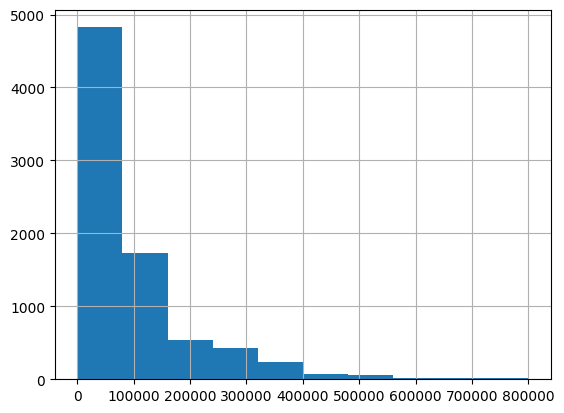

In [47]:
data["price"].hist()